In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
gen = np.random.default_rng()

In [40]:
A = [1, 2, 3]
B = [3, 1, 2]
categories = ["chores", "finances", "activities"]


In [41]:
def insist(x):
    return [0, 0, 0]


def compromise(x):
    return [1, 1, 1]


def random(x):
    return gen.integers(2, size=3)


def titfortat(x):
    if x[1] == []:
        return [1, 1, 1]
    return x[1][-1]


def grim(x):
    if x[1] == []:
        return [1, 1, 1]
    return np.minimum(x[1][-1], x[0][-1])


def gradual_forgiving(x, n=5):
    if x[1] == []:
        return [1, 1, 1]

    return np.min(x[1][-n:], axis = 0)

strategies = [insist, compromise, titfortat, grim, gradual_forgiving, random]

In [42]:
def game(strategy_A, strategy_B, N):
    choices = [[], []]
    for _ in range(N):
        a = strategy_A(choices)
        b = strategy_B(choices[::-1])
        choices[0].append(a)
        choices[1].append(b)
    return np.transpose(np.array(choices))

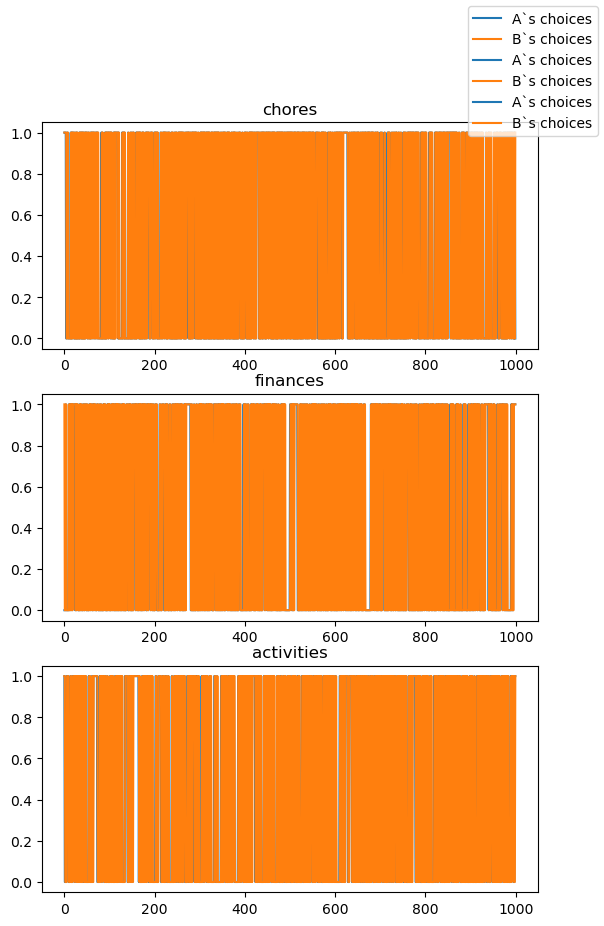

In [43]:
choices = game(random,titfortat,N=1000)
fig, ax = plt.subplots(3)
fig.set_figheight(10)

for i in range(3):
    ax[i].plot(choices[i], label=[f'A`s choices', f'B`s choices'])
    ax[i].set_title(categories[i])
fig.legend()
plt.show()

In [44]:
subgame_payoffs = np.array([[
    [[0, 0],        [A[i], -B[i]]],
    [[-A[i], B[i]], [1.5, 1.5]]]
    for i in range(3)])


def mean_payoffs(strategy_A, strategy_B, N=10000):
    choices = game(strategy_A, strategy_B, N)
    ret = np.zeros(2)
    for i in range(3):  # subgame
        for j in range(len(choices[0])):  # iteration
            ret += subgame_payoffs[i, choices[i, j, 0], choices[i, j, 1]]
    return np.round(ret/N, 2)

In [45]:
N = 10000

payoffs = []
for i in range(len(strategies)):
    payoffs.append([])
    for j in range(len(strategies)):
        payoffs[-1].append(mean_payoffs(strategies[i], strategies[j], N = N))

In [46]:
labels = [x.__name__ for x in strategies]
df = pd.DataFrame(payoffs, index=labels, columns=labels)
df
# print(df.to_latex())

,insist,compromise,titfortat,grim,gradual_forgiving,random
insist,"[0.0, 0.0]","[6.0, -6.0]","[0.0, -0.0]","[0.0, -0.0]","[0.0, -0.0]","[2.98, -2.97]"
compromise,"[-6.0, 6.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[-0.74, 5.26]"
titfortat,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[1.12, 1.12]"
grim,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.97, -2.97]"
gradual_forgiving,"[-0.0, 0.0]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[4.5, 4.5]","[2.9, -2.77]"
random,"[-3.02, 3.01]","[5.26, -0.75]","[1.11, 1.11]","[-3.0, 2.99]","[-2.75, 2.9]","[1.15, 1.05]"


In [ ]:
def stochastic(x, p):
    if x[1] == [] or x[0] == []:
        return [1,1,1]
    p = np.array(p)
    prob = p[2 * np.array(x[0][-1]) + np.array(x[1][-1])]

    return [gen.choice(a=2, p = [1 - prob[i], prob[i]]) for i in range(3)]

In [ ]:
p = [0,1,0,1] # p_dd, p_dc, p_cd, p_cc
stoch = lambda x:stochastic(x,p)
game(stoch,grim,N=100)

In [ ]:
M = 25 # number of strategies
N = 100 # number of rounds each game
Q = 35 # number of iterations
pruned = 3
evolution_rate = 0.1

score_iter = np.zeros([Q, M])
p = gen.uniform(size = [M,4])
p[0] = [0,1,0,1]
for k in range(Q):
    for i in range(M):
        sA = lambda x: stochastic(x,p[i])
        for sB in strategies:
            payoff = mean_payoffs(sA, sB, N = N)
            score_iter[k,i] += 2 * payoff[0]
        for j in range(M):
            sB = lambda x: stochastic(x,p[j])
            payoff = mean_payoffs(sA, sB, N = N)
            score_iter[k,i] += payoff[0]
            score_iter[k,j] += payoff[1]
    inds = np.argsort(score_iter[k])
    p = p[inds]
    p[:pruned] = p[-pruned:] + gen.normal(scale = evolution_rate)
    p = np.maximum(np.minimum(p,1),0)
score_iter /= 2 * (M + len(strategies))
print(score_iter[-1])

[0.86774194 0.88564516 0.81419355 3.81403226 3.80629032 3.82516129
 3.83806452 3.79612903 3.80564516 3.81935484 3.80467742 3.78435484
 3.81887097 3.78435484 3.81774194 3.82032258 3.81419355 3.7983871
 3.8033871  3.81129032 3.83145161 3.82806452 3.79064516 3.81645161
 3.82435484]


In [60]:
p

array([[0.30033328, 1.        , 0.30033328, 1.        ],
       [0.27447948, 1.        , 0.27447948, 1.        ],
       [0.22191402, 1.        , 0.22191402, 1.        ],
       [0.07708713, 1.        , 0.07708713, 1.        ],
       [0.09422496, 1.        , 0.09422496, 1.        ],
       [0.09359286, 1.        , 0.09359286, 1.        ],
       [0.08073589, 1.        , 0.08073589, 1.        ],
       [0.0450375 , 1.        , 0.0450375 , 1.        ],
       [0.0449066 , 1.        , 0.0449066 , 1.        ],
       [0.09342838, 1.        , 0.09342838, 1.        ],
       [0.05951508, 1.        , 0.05951508, 1.        ],
       [0.04921779, 1.        , 0.04921779, 1.        ],
       [0.07237205, 1.        , 0.07237205, 1.        ],
       [0.        , 1.        , 0.        , 1.        ],
       [0.07188902, 1.        , 0.07188902, 1.        ],
       [0.11416397, 1.        , 0.11416397, 1.        ],
       [0.06124786, 1.        , 0.06124786, 1.        ],
       [0.04855536, 1.        ,

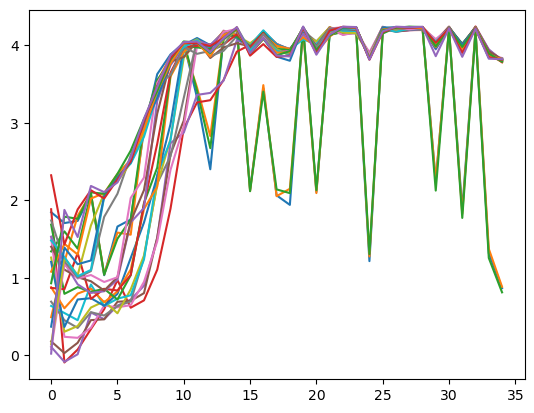

In [61]:
plt.plot(score_iter)
plt.show()